In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [4]:
def select_device(requested_device=None):
    """
    Selects the most appropriate device available for computations.
    If a device is specified, it checks if that device is available and uses it.
    If no device is specified, it defaults to CUDA if available, then MPS, and finally CPU.

    Parameters:
    - requested_device (str, optional): The requested device as a string (e.g., 'cuda', 'mps', 'cpu').

    Returns:
    - torch.device: The selected PyTorch device.
    - str: Description of the selected device.
    """
    if requested_device:
        # User has requested a specific device
        if requested_device == 'cuda' and torch.cuda.is_available():
            return torch.device('cuda'), "NVIDIA GPU"
        elif requested_device == 'mps' and torch.backends.mps.is_available():
            return torch.device('mps'), "Apple Silicon GPU"
        elif requested_device == 'cpu':
            return torch.device('cpu'), "CPU"
        else:
            raise ValueError(f"Requested device '{requested_device}' is not available or not recognized.")
    
    # Default selection logic if no device is specified
    if torch.cuda.is_available():
        return torch.device("cuda"), "NVIDIA GPU"
    elif torch.backends.mps.is_available():
        return torch.device("mps"), "Apple Silicon GPU"
    else:
        return torch.device("cpu"), "CPU"

# Select the best available device
device, device_name = select_device('mps') 
print(f"Using {device_name} for computation.")


Using Apple Silicon GPU for computation.


In [5]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path, parse_dates=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [6]:
df = load_and_prepare_data('../../data/Final_data/final_data.csv')

In [7]:
X, y = df.drop(columns=['Day_ahead_price']), df.Day_ahead_price.values
X.shape, y.shape

((4439, 18), (4439,))

In [8]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [9]:
X_trans

array([[-0.6651551 , -2.49860347, -0.81722557, ...,  0.05220774,
         1.02920119, -0.37789554],
       [-0.6651551 , -2.49860347,  0.06490721, ...,  0.0320909 ,
         1.0688494 , -1.50732521],
       [-0.6651551 , -2.49860347, -0.40204338, ...,  1.51682761,
         3.26536046, -1.22862467],
       ...,
       [ 0.93730573,  0.81712787, -0.85642649, ..., -0.51240293,
        -0.42985309, -2.88054082],
       [ 0.93730573,  0.82705596, -0.93338389, ..., -0.81405201,
        -0.94527988, -2.8580165 ],
       [ 0.96455268,  0.78344776, -1.11964042, ...,  0.6879487 ,
        -0.13645631, -1.4608451 ]])

In [10]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(4291, 100, 18) (4291, 50)


In [11]:
total_samples = len(X)
train_test_cutoff = round(0.80 * total_samples)
print(total_samples-train_test_cutoff)
 

888


In [12]:
X_train = X_ss[:-888]
X_test = X_ss[-888:]

y_train = y_mm[:-888]
y_test = y_mm[-888:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (3403, 100, 18) (3403, 50)
Testing Shape: (888, 100, 18) (888, 50)


In [13]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [14]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([3403, 100, 18]) torch.Size([3403, 50])
Testing Shape: torch.Size([888, 100, 18]) torch.Size([888, 50])


In [15]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [16]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 10 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [17]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 100 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 18 # number of features
hidden_size = 200 # number of features in hidden state
num_layers = 3 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [18]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [19]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

RuntimeError: The size of tensor a (10209) must match the size of tensor b (3403) at non-singleton dimension 0

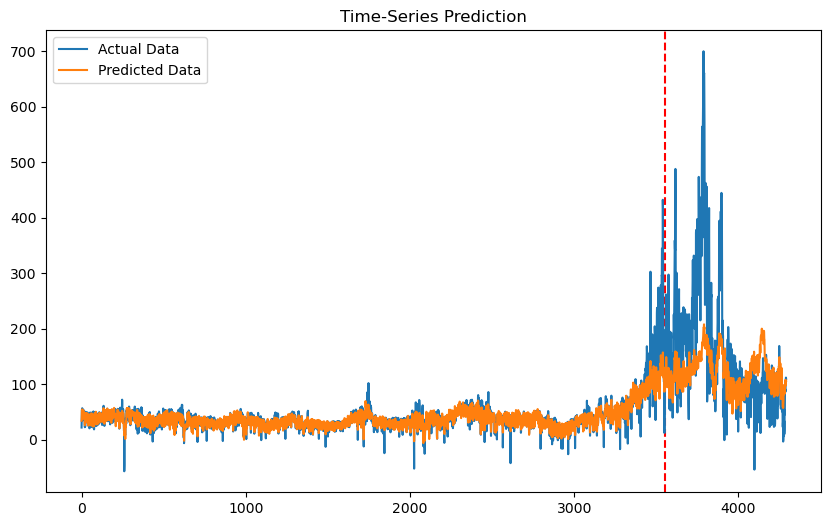

In [ ]:
df_X_ss = ss.transform(df.drop(columns=['Day_ahead_price'])) # old transformers
df_y_mm = mm.transform(df.Day_ahead_price.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

In [ ]:
def compute_metrics(predictions, actuals):
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)  # RMSE is just the square root of MSE

    return mse, mae, rmse
    
    # Assume 'predictions' and 'actuals' are numpy arrays obtained from the evaluate_model function
mse, mae, rmse = compute_metrics(preds, true)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 2221.742
Mean Absolute Error (MAE): 17.849644
Root Mean Squared Error (RMSE): 47.135357


In [ ]:
# Compute the MAPE for the results
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(true, preds)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 34.27877426147461


### Maybe use the next part in the future for prediction of future values with synthetic data set 

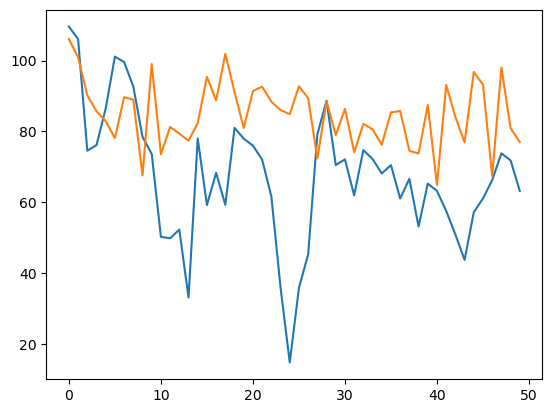

In [ ]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show()

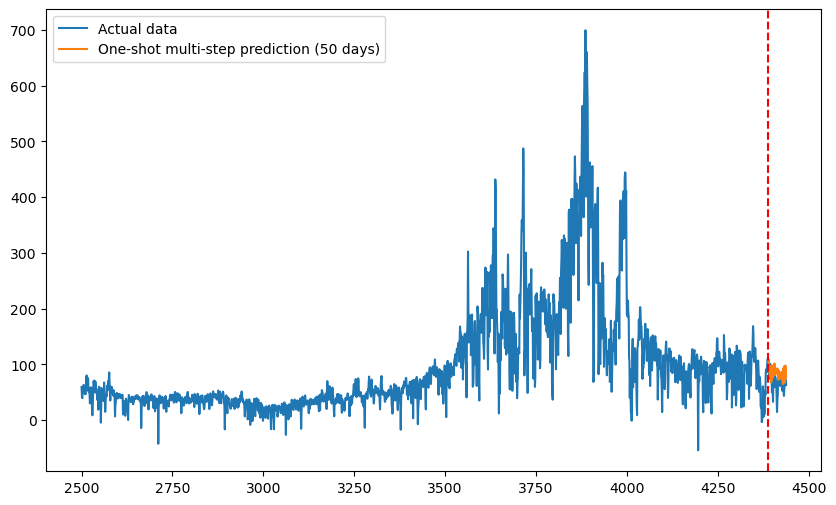

In [ ]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()